# Preprocessing, Modeling

In [1]:
# Importing our libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
import datetime as dt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import (roc_auc_score, confusion_matrix, recall_score, precision_score, 
                             roc_curve, f1_score, plot_confusion_matrix)

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, plot_importance
import shap

In [2]:
# Ensuring notebook remains tidy
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Setting our seaborn style and palette
sns.set_style('darkgrid')
sns.set_palette('icefire')

In [4]:
# Creating a custom function to kick-start the EDA process
def eda_clean(df):
    print('Dataset Statistics:')
    print(f'Shape of dataframe: {df.shape}')
    print('--------------------------------------')
    print(f'Null values in dataframe: {df.isna().sum().sum()}')
    print('--------------------------------------')
    print(f'% of Null values in dataframe: {round(((df.isna().sum().sum())/(df.shape[0])) * 100, 2)}%')
    print('--------------------------------------')
    print(f"Total duplicate rows: {df[df.duplicated()].shape[0]}")
    print('--------------------------------------')
    print(f"% duplicate rows: {round(df[df.duplicated()].shape[0] / df.shape[0] * 100, 2)}%")
    print(f'\nColumn names: {df.columns}')
    print('\nVariable Types')
    print(f"Columns Count: \n{df.dtypes.value_counts()}")

In [5]:
# Import our tidied train dataset
train_transformed = pd.read_csv('../data/cleaned/train_tidied.csv')

In [6]:
# Dropping redundant columns
train_transformed.drop(columns=['date', 'addressnumberandstreet', 'year_month', 'station', 'station_ref', 'year'], inplace=True)

In [7]:
# Dropping null and nan columns
train_transformed.dropna(inplace=True)

In [8]:
# Defining X and y variables for our train split
X = train_transformed.drop(columns='wnvpresent')
y = train_transformed['wnvpresent']

In [9]:
# Do a train-test split of 70-30 for train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    stratify=y, # Because this is an unbalanced dataset
                                                    random_state=42)

In [10]:
# # generates the full polynomial feature table
# pf = PolynomialFeatures(include_bias=False, degree=2)
# X_train_pf = pf.fit_transform(X_train)

# # Adds appropriate feature names to all polynomial features
# X_train_pf = pd.DataFrame(X_train_pf, columns=pf.get_feature_names(X_train.columns))

In [11]:
# create function to run model with standard scaling, SMOTE sampling, 
# with an option to run grid search, model and print results

def run_model(mod, mod_params={}, grid_search=False):
    
    # Initial dictionary to hold model results
    results = {}
    
    pipe = Pipeline([
            ('ss', StandardScaler()),
            (mod, models[mod])
            ])
    
    if grid_search:
        # Instantiate list to store gridsearch results
        gs = GridSearchCV(pipe, param_grid=mod_params, cv=5, verbose=1, scoring='roc_auc', n_jobs=-1)
        gs.fit(X_train, y_train)
        pipe = gs
    else:
        pipe.fit(X_train, y_train)
        

    # Retrieve metrics
    predictions = pipe.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    y_test_pred_prob = pipe.predict_proba(X_test)[:,1]
    y_train_pred_prob = pipe.predict_proba(X_train)[:,1]
    auc_scores = cross_val_score(pipe, X_train, y_train,  scoring='roc_auc', cv = 5)

    results['model'] = mod
    
    results['train_auc_cv'] = auc_scores.mean()
    
    results['f1'] = f1_score(y_test, predictions)
    results['recall'] = recall_score(y_test, predictions)        # % OF ACTUAL positives that are CORRECTLY predicted
    results['precision'] = precision_score(y_test, predictions)  # % OF positives that are CORRECTLY predicted

    results['train_auc'] = roc_auc_score(y_train, y_train_pred_prob)
    results['test_auc'] = roc_auc_score(y_test, y_test_pred_prob)
    results['auc_diff'] = results['train_auc'] - results['test_auc']

    if grid_search:
        gs_list.append(results)
        print('### BEST PARAMS ###')
        display(pipe.best_params_)
        
    else:
        init_list.append(results)

    return pipe

In [12]:
%%time

X_train_copy = X_train.astype(float).copy()
y_train_copy = y_train.astype(float).copy()

# create loop to run SMOTE sampling and compare the modelling outcomes with and without it
for k in ['No', 'SMOTE']:
    print('\nMethod Used: {}'.format(k + ' sampling'), "-" * 100)
        
    print('\nClass Balance BEFORE')
    display(y_train.value_counts(normalize=True))
    print('Number of rows: {}'.format(y_train.shape[0]))
  
    # instiantiate the models
    methods = {'SMOTE': SMOTE(random_state=42)}
    
    if k == 'SMOTE':
        mthd = methods[k]
        X_train, y_train = mthd.fit_resample(X_train, y_train)

    print('\nClass Balance AFTER')
    display(y_train.value_counts(normalize=True))
    print('Number of rows: {}'.format(y_train.shape[0]),'\n')
    
    
    # Instiantiate models
    models = {'lr': LogisticRegression(max_iter=5_000, random_state=42, solver='saga'),
              'rf': RandomForestClassifier(random_state=42),
              'gb': GradientBoostingClassifier(random_state=42),
              'dt': DecisionTreeClassifier(random_state=42),
              'et': ExtraTreesClassifier(random_state=42),
              'ada': AdaBoostClassifier(random_state=42),
              'svc': SVC(random_state=42, probability=True),
              'xgb': XGBClassifier(random_state=42, 
                              objective='binary:logistic', 
                              verbosity=1, n_jobs=-1)
            }

    # Instantiate lists to store results
    init_list = []
    gs_list = []

    for m in models:
        run_model(m)
    result_df = pd.DataFrame(init_list).sort_values(by=["f1"], ascending=False).reset_index(drop=True)
    display(result_df)

    X_train = X_train_copy
    y_train = y_train_copy


Method Used: No sampling ----------------------------------------------------------------------------------------------------

Class Balance BEFORE


0    0.945643
1    0.054357
Name: wnvpresent, dtype: float64

Number of rows: 5887

Class Balance AFTER


0    0.945643
1    0.054357
Name: wnvpresent, dtype: float64

Number of rows: 5887 

[19:49:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:49:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:49:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:49:48] WARNING: C:/Users/Administrator/work

,model,train_auc_cv,f1,recall,precision,train_auc,test_auc,auc_diff
0,gb,0.840480,0.014388,0.007299,0.500000,0.887527,0.827499,0.060027
1,dt,0.796072,0.014388,0.007299,0.500000,0.903984,0.767932,0.136051
2,et,0.795216,0.014388,0.007299,0.500000,0.903984,0.766027,0.137956
3,xgb,0.825842,0.014388,0.007299,0.500000,0.903528,0.818645,0.084883
4,rf,0.798006,0.014286,0.007299,0.333333,0.903650,0.777536,0.126114
5,lr,0.801566,0.000000,0.000000,0.000000,0.817895,0.790806,0.027089
6,ada,0.838430,0.000000,0.000000,0.000000,0.871348,0.828083,0.043265
7,svc,0.743474,0.000000,0.000000,0.000000,0.769611,0.697245,0.072365



Method Used: SMOTE sampling ----------------------------------------------------------------------------------------------------

Class Balance BEFORE


0.0    0.945643
1.0    0.054357
Name: wnvpresent, dtype: float64

Number of rows: 5887

Class Balance AFTER


0.0    0.5
1.0    0.5
Name: wnvpresent, dtype: float64

Number of rows: 11134 

[19:51:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:51:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:51:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:51:56] WARNING: C:/Users/Administrator/wor

,model,train_auc_cv,f1,recall,precision,train_auc,test_auc,auc_diff
0,rf,0.954666,0.278481,0.562044,0.185096,0.962982,0.771542,0.191439
1,ada,0.928561,0.278184,0.693431,0.173993,0.931800,0.816479,0.115322
2,dt,0.954548,0.270370,0.532847,0.181141,0.963504,0.763963,0.199541
3,et,0.953787,0.269871,0.532847,0.180693,0.963504,0.762107,0.201397
4,xgb,0.959170,0.268336,0.547445,0.177725,0.963382,0.812113,0.151268
5,gb,0.947904,0.262751,0.620438,0.166667,0.951018,0.811792,0.139226
6,svc,0.912391,0.253333,0.693431,0.154976,0.921335,0.812503,0.108831
7,lr,0.824658,0.214365,0.708029,0.126302,0.826088,0.775281,0.050807


Wall time: 2min 43s


## Selection of our final model (XGBoost)

In [13]:
# Creating a pipeline model for StandardScaler, SMOTE and XGBoost
xgb_pipe = Pipeline([
        ('ss', StandardScaler()),
        ('xgb', XGBClassifier(random_state=42, 
                              objective= 'binary:logistic', 
                              verbosity=1, n_jobs=-1))
    ])
# Parameters
xgb_params = {  'xgb__learning_rate': [0.1],
                'xgb__max_depth': [50],
                'xgb__min_child_weight': [25],
                'xgb__gamma': [0.85],
                'xgb__subsample': [1],
                'xgb__scale_pos_weight': [63],
                'xgb__n_estimators': [49]}

In [14]:
%%time

xgb_best = run_model('xgb', xgb_params, grid_search=True)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[19:52:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[19:52:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[19:52:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' wa

{'xgb__gamma': 0.85,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 50,
 'xgb__min_child_weight': 25,
 'xgb__n_estimators': 49,
 'xgb__scale_pos_weight': 63,
 'xgb__subsample': 1}

Wall time: 18.2 s


In [15]:
# create table to show the predictors with the highest importance (i.e. strongest predictors of the presence of WNV)
feature_names = X.columns
coefficients = pd.DataFrame(np.squeeze(xgb_best.best_estimator_.named_steps["xgb"].feature_importances_),
                            columns=['Importances']) 
features = pd.DataFrame(np.squeeze(feature_names), columns=['Features']) 
df = pd.concat([features, coefficients], axis='columns').sort_values('Importances', ascending=False)
df

,Features,Importances
1,week,0.260906
13,raining,0.069774
4,PIPIENS,0.057277
27,humidity_10ma,0.055098
31,misty_5sum,0.048477
0,month,0.048215
12,avgspeed,0.043690
26,avgspeed_10ma,0.040667
21,humidity_5ma,0.032045
22,preciptotal_5ma,0.028993


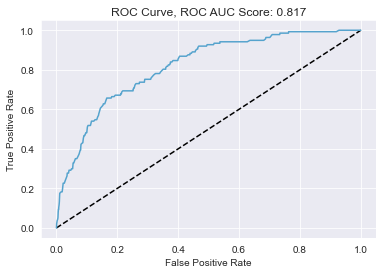

In [16]:
y_pred_prob = xgb_best.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve, ROC AUC Score: {}'.format(roc_auc_score(y_test, y_pred_prob).round(3)))
plt.show()

## Tidying ```test``` data

In [17]:
# Read train and test datasets
test = pd.read_csv('../data/raw/test.csv', parse_dates=['Date'])

# Converting columns to lowercase for standardisation
test.columns = test.columns.str.lower()

In [18]:
# Previewing our test dataset
eda_clean(test)

Dataset Statistics:
Shape of dataframe: (116293, 11)
--------------------------------------
Null values in dataframe: 0
--------------------------------------
% of Null values in dataframe: 0.0%
--------------------------------------
Total duplicate rows: 0
--------------------------------------
% duplicate rows: 0.0%

Column names: Index(['id', 'date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy'],
      dtype='object')

Variable Types
Columns Count: 
object            5
int64             3
float64           2
datetime64[ns]    1
dtype: int64


In [19]:
def initial_clean(df):
    df.drop(columns=['address', 'block', 'street', 'addressaccuracy'], inplace=True)
    return df

In [20]:
test_iter1 = initial_clean(test)

In [21]:
def date_feature_engineering(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['week'] = df['date'].dt.isocalendar().week
    df['day'] = df['date'].dt.isocalendar().day
    df['year_month'] = df['date'].dt.strftime("%Y-%m")

    return df

In [22]:
test_iter2 = date_feature_engineering(test_iter1)

In [23]:
# We can exclude Unsepcified species from this selection
species_of_interest = ['RESTUANS', 'PIPIENS', 'SALINARIUS', 'TERRITANS', 'TARSALIS', 'ERRATICUS']

# create loop to create dummified variables to indicate presence of Pipiens & Restuans species
def dummify_species(df):
    for i in species_of_interest:
        df[i] = df['species'].apply(lambda x: 1 if i in x else 0)
    
    return df

In [24]:
test_iter3 = dummify_species(test_iter2)

In [25]:
def determine_station(lat, long):
    station1 = (41.995, -87.933) #Chicago O'Hare Tntl Airpot -> lat: 41.995 long: -87.933
    station2 = (41.786, -87.752) #Chicago Midway Tntl Airpot -> lat: 41.786 long: -87.752
    coordinates = (lat, long)
    
    return 1 if geodesic(coordinates, station1) < geodesic(coordinates, station2) else 2

In [26]:
%%time

# Apply function to map our function
test_iter3['station_ref'] = test_iter3.apply(lambda i: determine_station(i['latitude'], i['longitude']), axis=1)

Wall time: 56.4 s


In [27]:
weather_tidied = pd.read_csv('../data/cleaned/weather_tidied.csv', parse_dates=['date'])

In [28]:
test_iter4 = test_iter3.merge(weather_tidied, how='left', left_on=['station_ref', 'date'], right_on=['station', 'date'])
test_iter4.drop(columns=["station"], inplace=True)

In [29]:
def final_clean(df):
    df.drop(columns=['species', 'trap', 'date', 'addressnumberandstreet', 
                     'latitude', 'longitude', 
#                      'day', 
                     'year_month', 'station_ref', 'year'], inplace=True)
    
    return df

In [30]:
test_iter5 = final_clean(test_iter4)

In [31]:
def predict(df):
    df_id = df['id']

    df_base = df.drop(columns=['id'])
    
    # generate predictions
    y_pred = ada_best.best_estimator_.predict(df_base)  

    # load prediction into dataframe
    df_pred = pd.DataFrame(np.squeeze(y_pred), columns=['wnvpresent']) 

    # Merge id with predictions into one dataframe
    df_final = pd.concat([df_id, df_pred], axis='columns')
    return df_final

def predict_proba(df):
    df_coord = test[['latitude', 'longitude']]
    
    df_base = df.drop(columns=['id'])
    
    # generate predictions
    y_pred = ada_best.best_estimator_.predict_proba(df_base)  

    # load prediction into dataframe
    df_pred = pd.DataFrame(np.squeeze(y_pred)) 

    # Merge id with predictions into one dataframe
    df_final = pd.concat([df_coord, df_pred], axis='columns')
    return df_final

In [32]:
def predict_best(df, model_best):
    df_id = df['id']

    df_base = df.drop(columns=['id'])
    
    # generate predictions
    y_pred = model_best.best_estimator_.predict(df_base)  

    # load prediction into dataframe
    df_pred = pd.DataFrame(np.squeeze(y_pred), columns=['wnvpresent']) 

    # Merge id with predictions into one dataframe
    df_final = pd.concat([df_id, df_pred], axis='columns')
    return df_final

def predict_proba_best(df, model_best):
    df_coord = test[['latitude', 'longitude']]
    
    df_base = df.drop(columns=['id'])
    
    # generate predictions
    y_pred = model_best.best_estimator_.predict_proba(df_base)  

    # load prediction into dataframe
    df_pred = pd.DataFrame(np.squeeze(y_pred)) 

    # Merge id with predictions into one dataframe
    df_final = pd.concat([df_coord, df_pred], axis='columns')
    return df_final

In [33]:
# generate predictions
pred = predict_best(test_iter5, xgb_best)

In [34]:
pred.rename(columns={'id': 'Id', 'wnvpresent':'WnvPresent'}, inplace=True)

In [35]:
pred = pred.set_index('Id')

In [36]:
pred.to_csv('../kaggle/submission.csv')

**Kaggle Submission Score**

![Our Kaggle submission](../images/kaggle_submission.png "Our Kaggle submission")